In [1]:
# import the libraries
import os # to get the path of the files
import sys # to get the arguments
import numpy as np # to work with arrays
import pandas as pd # to work with dataframes
import gc # to clean the memory

import itertools # to work with iterators
from tqdm.autonotebook import tqdm # to show the progress bar
import matplotlib.pyplot as plt # to show the images
from glob import glob # to get the path of the files
import PIL.Image as Image # to work with images
import numpy as np # to work with arrays
import matplotlib.pyplot as plt # to show the images

import torch # to build the model
from torch import nn # to build the model
import torch.nn.functional as F # to build the model
# import torchvision.transforms as transforms # to build the model
from torchvision import transforms,datasets,utils
import timm # to build the model

from torch.utils.data import Dataset, DataLoader # to build the model
from torch.utils.data.sampler import SequentialSampler, RandomSampler # to build the model
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau # to build the model

/tmp/ipykernel_30/3698632166.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm # to show the progress bar


In [2]:
#defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = torch.get_num_threads()*2
print("Number of workers:", num_workers)

batch_size = 128
print("Batch size:", batch_size)
img_size = 224

cuda
Number of workers: 2
Batch size: 128


In [3]:
# data transforms
transforms_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_valid = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# dataset class
train_ds = datasets.ImageFolder(root = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Train',
                               transform = transforms_train)

valid_ds = datasets.ImageFolder(root = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Val',
                                 transform = transforms_valid)

test_ds = datasets.ImageFolder(root = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Test',
                                    transform = transforms_valid)


In [5]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
# get classes dictionary
classes = train_ds.class_to_idx
classes

{'Normal': 0, 'bacteria': 1, 'virus': 2}

In [7]:
def plot_one_batch(dl):
    for images, labels in dl:
        images_denorm = images*0.225 + 0.45
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(utils.make_grid(images_denorm[:25], nrow=5).permute(1, 2, 0))
        break

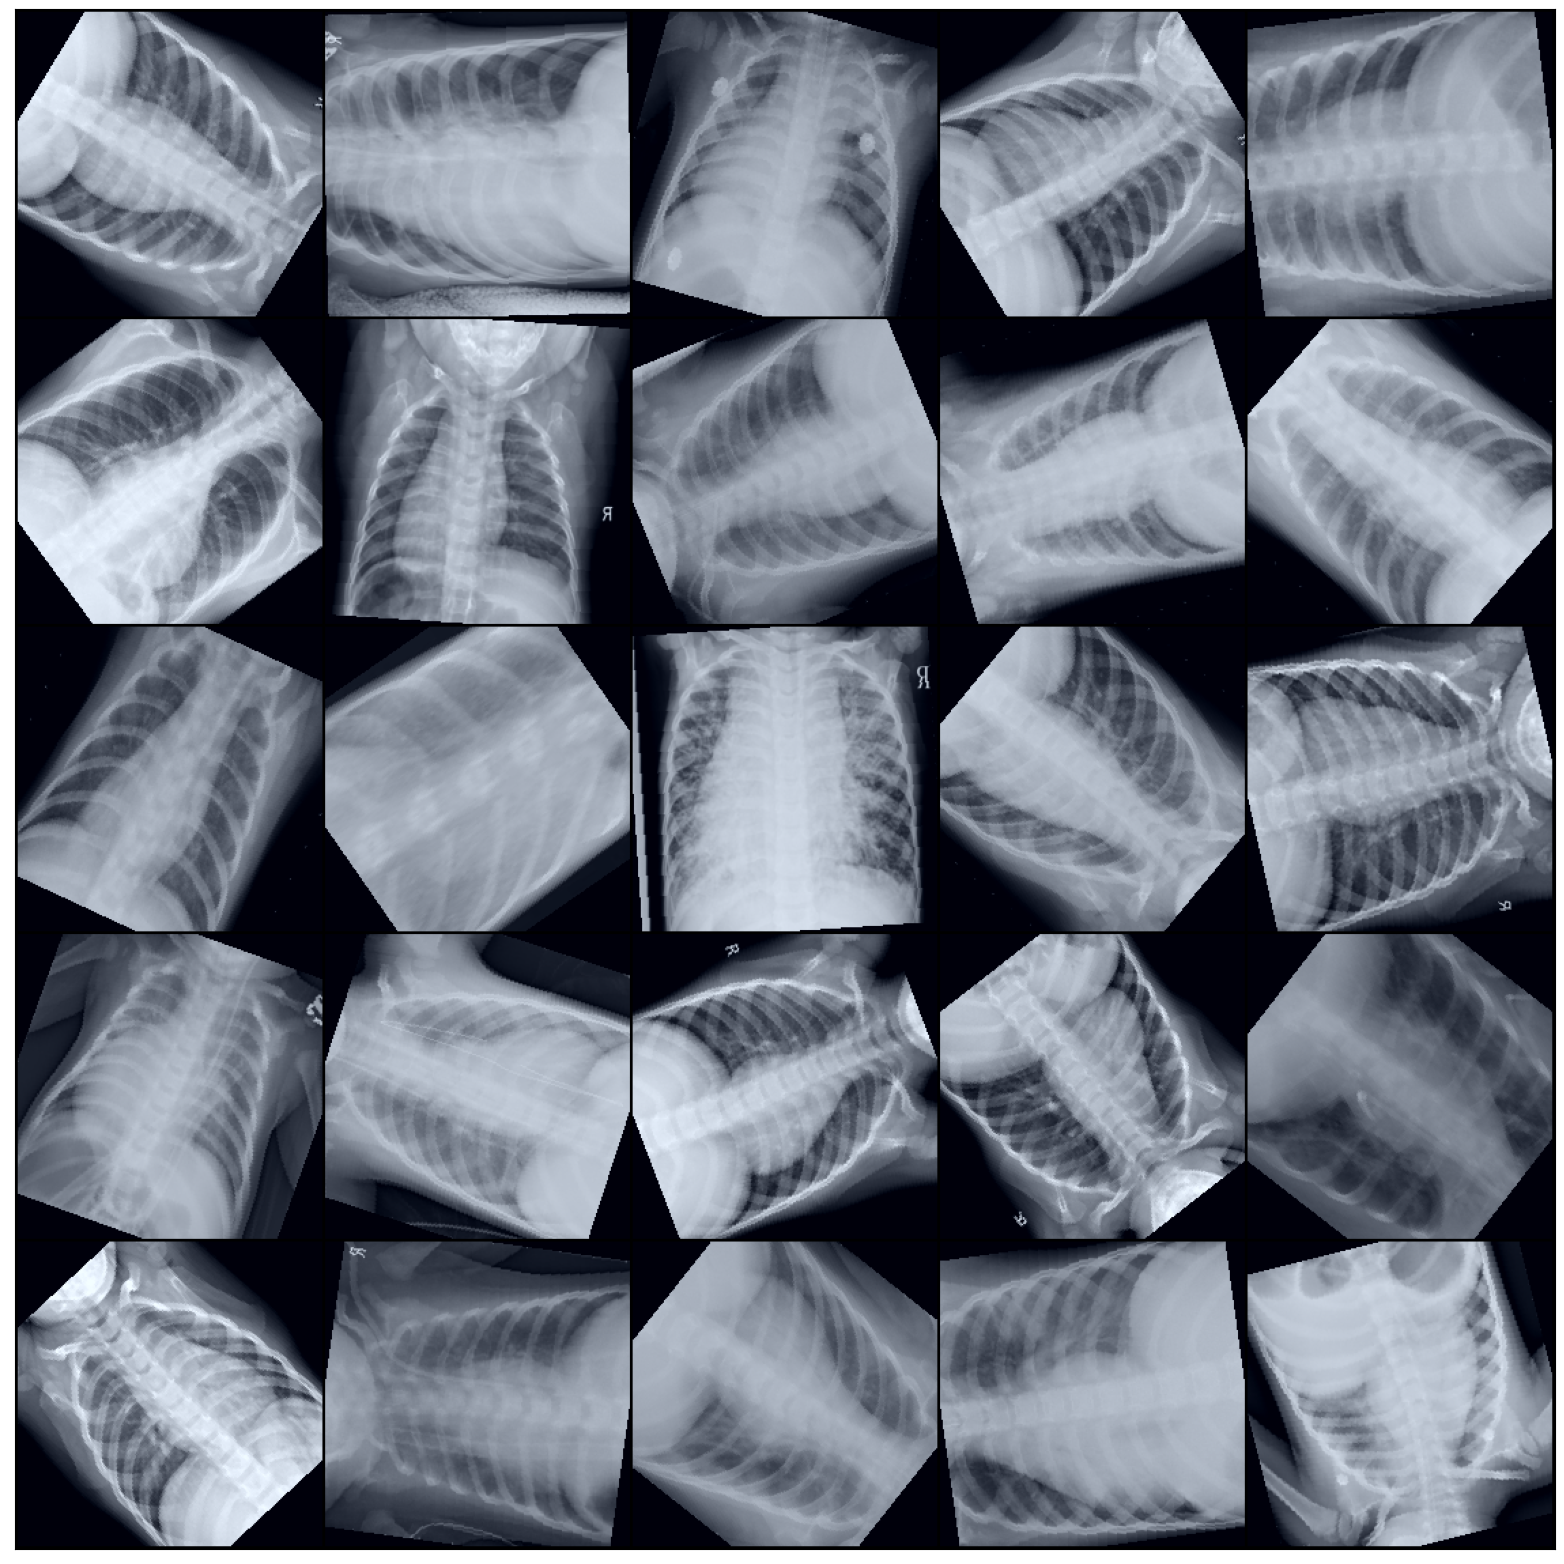

In [8]:
plot_one_batch(train_dl)


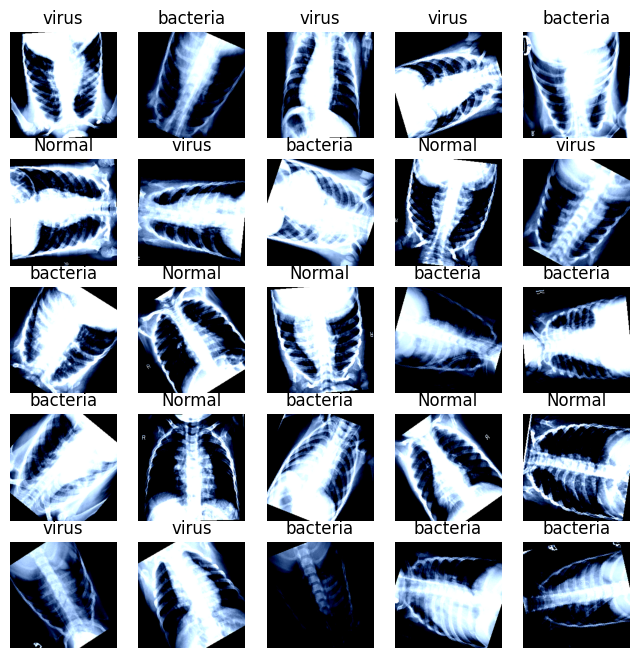

In [9]:
def sample(dl):
    images, labels = next(iter(dl))
    fig=plt.figure(figsize=(8, 8))
    columns = 5
    rows = 5
    for i in range(1, columns*rows +1):
        img = images[i]
        fig.add_subplot(rows, columns, i)
        #hide the axis
        plt.axis('off')
        #add the title
        real_label = list(classes.keys())[list(classes.values()).index(labels[i].item())]
        plt.title(real_label)
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

sample(train_dl)

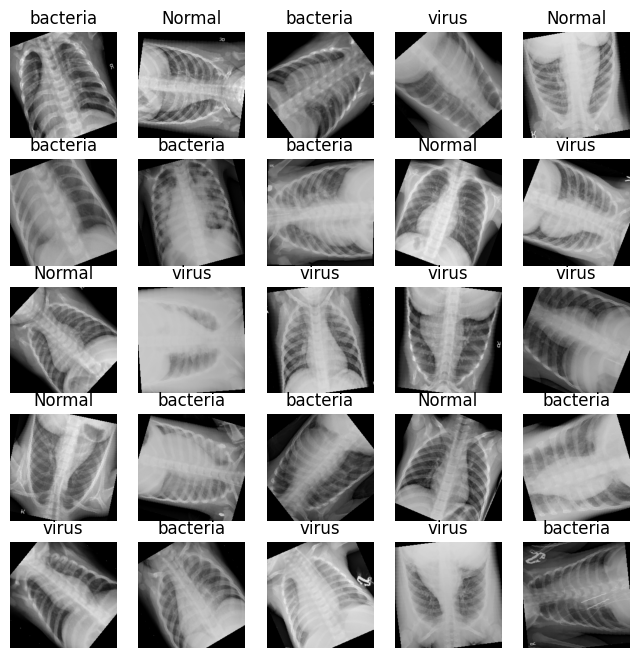

In [10]:
def sample_denorm(dl):
    images, labels = next(iter(dl))
    images_denormalized = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    fig=plt.figure(figsize=(8, 8))
    columns = 5
    rows = 5
    for i in range(1, columns*rows +1):
        img = images_denormalized[i]
        fig.add_subplot(rows, columns, i)
        #hide the axis
        plt.axis('off')
        #add the title
        real_label = list(classes.keys())[list(classes.values()).index(labels[i].item())]
        plt.title(real_label)
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

sample_denorm(train_dl)

In [11]:
class GraphClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, len(classes))
        # stop the model from training
        for param in self.model.parameters():
            param.requires_grad = False
        # train the last layer
        for param in self.model.head.parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
model1 = GraphClassifier(model_name='vit_base_patch16_224', pretrained=True).to(device)


In [13]:
!pip install torchsummary
# summary of the model
from torchsummary import summary
summary(model1, input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
         LayerNorm-6             [-1, 197, 768]           1,536
            Linear-7            [-1, 197, 2304]       1,771,776
           Dropout-8         [-1, 12, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
          Dropout-10             [-1, 197, 768]               0
        Attention-11             [-1, 197, 768]               0
         Identity-12             [-1, 197, 768]               0
         Identity-13             [-1, 197, 768]               0
        LayerNorm-14             [-1, 1

In [14]:
# ! pip install torchviz

In [15]:
# #plot model architecture
# from torchviz import make_dot
# x = torch.randn(1, 3, img_size, img_size).to(device)
# vis_graph = make_dot(model(x), params=dict(model.named_parameters()))
# vis_graph.view()


In [18]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

# scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode="min", verbose=True)


In [21]:
# training function
def train(model, train_dl, valid_dl, criterion,epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode="min", verbose=True)

    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        # train
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_dl):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss/len(train_dl)
        train_losses.append(train_loss)
        # validate
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_dl):
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_dl)
            valid_losses.append(valid_loss)
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Valid loss: {valid_loss:.3f}")
        #save the best model
        if valid_loss == min(valid_losses):
            torch.save(model.state_dict(), 'best_model.pt')
        # update the learning rate
        scheduler.step(valid_loss)
    return train_losses, valid_losses


In [22]:
# train the model
epochs = 20
train_losses1, valid_losses1 = train(model1, train_dl, valid_dl, criterion,epochs)


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: 0.980.. Valid loss: 1.311


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: 0.841.. Valid loss: 1.194


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: 0.776.. Valid loss: 1.056


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: 0.724.. Valid loss: 1.041


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: 0.688.. Valid loss: 0.948


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: 0.668.. Valid loss: 1.015


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: 0.658.. Valid loss: 0.912


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: 0.649.. Valid loss: 0.941


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: 0.626.. Valid loss: 0.951


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: 0.617.. Valid loss: 0.930


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: 0.607.. Valid loss: 0.908


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20.. Train loss: 0.602.. Valid loss: 0.899


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20.. Train loss: 0.593.. Valid loss: 0.896


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20.. Train loss: 0.591.. Valid loss: 0.914


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20.. Train loss: 0.586.. Valid loss: 0.793


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20.. Train loss: 0.577.. Valid loss: 0.859


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20.. Train loss: 0.577.. Valid loss: 0.756


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20.. Train loss: 0.573.. Valid loss: 0.835


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20.. Train loss: 0.565.. Valid loss: 0.889


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20.. Train loss: 0.565.. Valid loss: 0.805


In [33]:
! mkdir best_models

In [34]:
! cp /kaggle/working/best_model.pt /kaggle/working/best_models/model1.pt

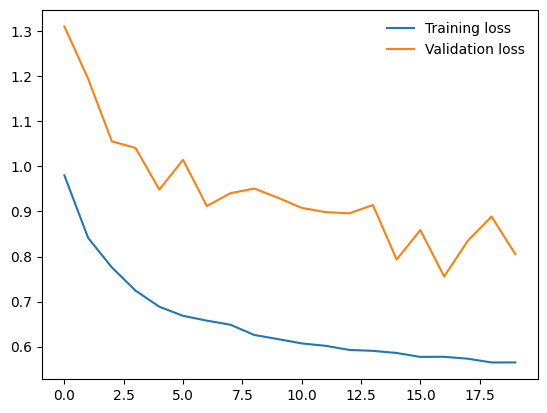

In [24]:
# plot the losses
plt.plot(train_losses1, label='Training loss')
plt.plot(valid_losses1, label='Validation loss')
plt.legend(frameon=False)

In [35]:
# load the best model
model1.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [36]:
# test the model
def test(model, test_dl):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dl):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            correct += (top_class == labels.view(*top_class.shape)).sum().item()
    test_loss = test_loss/len(test_dl)
    test_accuracy = correct/len(test_dl.dataset)
    print(f"Test loss: {test_loss:.3f}.. "
          f"Test accuracy: {test_accuracy:.3f}")
    return test_loss, test_accuracy

test_loss, test_accuracy = test(model1, test_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 0.790.. Test accuracy: 0.663


In [37]:
val_loss, val_accuracy = test(model1, valid_dl)


  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 0.756.. Test accuracy: 0.720


In [38]:
train_loss, train_accuracy = test(model1, train_dl)

  0%|          | 0/31 [00:00<?, ?it/s]

Test loss: 0.568.. Test accuracy: 0.751


In [39]:
# make new vit but train last 5 layers
# make the model
class GraphClassifier2(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, len(classes))
        # stop the model from training
        for param in self.model.parameters():
            param.requires_grad = False
        # train the last  5 layer
        for param in self.model.blocks[-5:].parameters():
            param.requires_grad = True
        for param in self.model.head.parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.model(x)
        return x
    

In [40]:
model2 = GraphClassifier2(model_name='vit_base_patch16_224', pretrained=True).to(device)
# model2.to(device)

# summary of the model


In [41]:
summary(model2, input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
         LayerNorm-6             [-1, 197, 768]           1,536
            Linear-7            [-1, 197, 2304]       1,771,776
           Dropout-8         [-1, 12, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
          Dropout-10             [-1, 197, 768]               0
        Attention-11             [-1, 197, 768]               0
         Identity-12             [-1, 197, 768]               0
         Identity-13             [-1, 197, 768]               0
        LayerNorm-14             [-1, 1

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/30.. Train loss: 1.583.. Valid loss: 0.886


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/30.. Train loss: 0.559.. Valid loss: 0.588


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/30.. Train loss: 0.505.. Valid loss: 0.579


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/30.. Train loss: 0.482.. Valid loss: 0.601


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/30.. Train loss: 0.467.. Valid loss: 0.646


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/30.. Train loss: 0.460.. Valid loss: 0.608


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/30.. Train loss: 0.421.. Valid loss: 0.631
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/30.. Train loss: 0.386.. Valid loss: 0.497


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/30.. Train loss: 0.366.. Valid loss: 0.505


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/30.. Train loss: 0.362.. Valid loss: 0.482


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/30.. Train loss: 0.363.. Valid loss: 0.499


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/30.. Train loss: 0.354.. Valid loss: 0.464


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/30.. Train loss: 0.348.. Valid loss: 0.488


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/30.. Train loss: 0.344.. Valid loss: 0.487


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/30.. Train loss: 0.337.. Valid loss: 0.467


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/30.. Train loss: 0.339.. Valid loss: 0.462


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/30.. Train loss: 0.346.. Valid loss: 0.479


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/30.. Train loss: 0.339.. Valid loss: 0.463


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/30.. Train loss: 0.332.. Valid loss: 0.511


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/30.. Train loss: 0.326.. Valid loss: 0.507
Epoch 00020: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/30.. Train loss: 0.325.. Valid loss: 0.467


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/30.. Train loss: 0.316.. Valid loss: 0.475


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/30.. Train loss: 0.316.. Valid loss: 0.466


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/30.. Train loss: 0.314.. Valid loss: 0.466
Epoch 00024: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/30.. Train loss: 0.312.. Valid loss: 0.467


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/30.. Train loss: 0.310.. Valid loss: 0.468


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/30.. Train loss: 0.317.. Valid loss: 0.469


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/30.. Train loss: 0.310.. Valid loss: 0.470
Epoch 00028: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/30.. Train loss: 0.315.. Valid loss: 0.470


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/30.. Train loss: 0.306.. Valid loss: 0.470


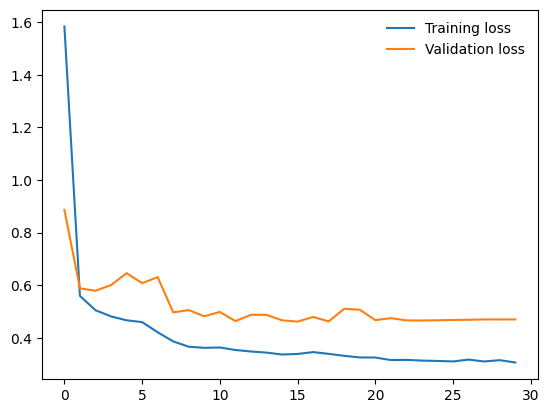

In [42]:
# train the model
epochs = 30
train_losses2, valid_losses2 = train(model2, train_dl, valid_dl, criterion, epochs)

# plot the losses
# plot the losses
plt.plot(train_losses2, label='Training loss')
plt.plot(valid_losses2, label='Validation loss')
plt.legend(frameon=False)


In [43]:
! cp /kaggle/working/best_model.pt /kaggle/working/best_models/model2.pt

In [71]:
# model2.load_state_dict(torch.load('best_model.pt'))

In [45]:
test_loss2, test_accuracy2 = test(model2, test_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 0.384.. Test accuracy: 0.833


In [47]:
train_loss2, train_accuracy2 = test(model2, train_dl)

  0%|          | 0/31 [00:00<?, ?it/s]

Test loss: 0.340.. Test accuracy: 0.861


In [46]:
val_loss2, val_accuracy2 = test(model2, valid_dl)


  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 0.462.. Test accuracy: 0.817
